#Import Libraries
First we will need to import tensorflow to train a machine learning model that can classify hand written digits.

We will also import the tensorflow datasets library so that we can load our MNIST dataset.

We also import matplotlib, which we will use to display the images.

Next, we import keras and its constituents such as Model, Convo3D, MaxPooling2D etc. You will soon understand how they work

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
import warnings
warnings.filterwarnings("ignore")

Let's load our data.

We will use the function `tfds.load()` to get a nicely prepackaged and cleaned dataset. Let's take a look at the parameters we pass to this function.

1. `'mnist`' - this downloads the MNIST dataset, which is the dataset we want. There are a lot of other datasets available but each of them require a different approach so we will focus on just mnist for today.
2. `split=['train', 'test]` this splits our training data into two parts, a train set and a test set. The trainset has 60,000 examples and the test set has 10,000. This allows us to check our work
3. `shuffle_files=True` will make sure we shuffle our data up. We don't want our nueral network to guess what digit it is looking at based on the previous number it looked at. If we didn't shuffle, the nueral network would just learn that if the last number it saw was a 5, for example, the next number must be 6, and so forth.
4. `as_supervised=True` just makes the format of the data equivalent to a bunch of tuples of the form: `(image of digit, label of digit)`. As we learned in our Intro workshop, tuples cannot be edited, which is useful here so we do not accidentally shuffle the images and labels of digits.
5. `with_info` will grab some more info about the dataset for us to look at.



Feel free to read up more about the MNIST dataset at this link: https://www.tensorflow.org/datasets/catalog/mnist or read more about it by running the cell below to see `dataset_info`.

In [18]:
(dataset_train, dataset_test), dataset_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True, #turning this to false, we get dictionary w keys (ewww)
    with_info=True,
)

In [27]:
#print(dataset_info.splits['train'].num_examples)
#print(dataset_info.splits['test'].num_examples)
dataset_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

Next we are going to prepare our dataset so that we can use it to train our model.

Let's first take a look at the first example in our dataset.
The first element is a tuple, with two elements as you can see in the code cell below.

Each element in our dataset is of type: <class 'tuple'>
The label of this element is: tf.Tensor(4, shape=(), dtype=int64)
The shape of this image is: (28, 28, 1)


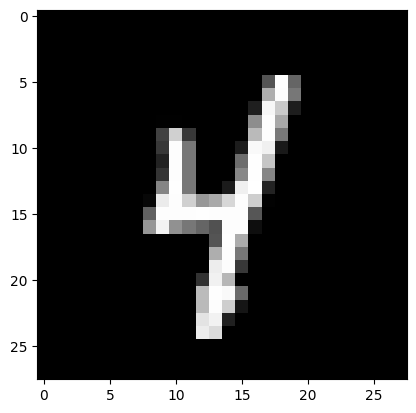

In [34]:
for x in dataset_train:
    img, label = x
    plt.imshow(img[:,:,0], cmap='gray')

    print("Each element in our dataset is of type:", type(x))
    print("The label of this element is:", label) #ASK HERE
    print("The shape of this image is:", img.shape)

    break

First we need to convert the data type of the images from unsigned 8-bit integers to 32-bit float. This is because the nueral network we will use expects 32-bit floats.

Next we will devide the images by 255 because that will keep all the values in the image between 0 and 1 rather than between 0 and 255.
Having smaller values allows training to go faster. Otherwise, the activation functions destabilize (as most of them expect values in range [-5,5] and work best in [-1,1] range), and causes a problem called vanishing gradients.

We also batch our data. This means we split our 60,000 training examples into batches or groups of 128 examples and train on those. This allows our model to view 128 different images and their labels at once and learn from them all at the same time. This means it will be almost 128x as fast to train! It will also use more GPU, so keep an eye out on System and GPU RAM to avoid exhausting the memory.

In [9]:
def normalize_img(image, label):
    """Normalizes images from unsigned 8-bit integers to 32-bit float.
    Also scales all values to be between 0 and 1 rather than 0 and 255."""
    image = tf.cast(image, tf.float32) #going from 0-255 to decimals

    # rescale the image to be between 0 and 1 by dividing it by 255
    image = image / 255 # DO THIS TO SPEED UP TRAINING PROCESS SINCE SMALLER NUMBER SIZES ARE PROCESSED MORE SMOOTHLY BY NEURAL NETWORKS

    return image, label

# apply our normalization function to our dataset
dataset_train = dataset_train.map(normalize_img)

# next we shuffle up our training data again
dataset_train = dataset_train.shuffle(dataset_info.splits['train'].num_examples)

# finally we batch our data to allow us to train faster
dataset_train = dataset_train.batch(128)

#ASK HERE
# do the same for our testing data. Make sure to normalize it and to batch it only
# no need to shuffle.
dataset_test = dataset_test.map(normalize_img)
dataset_test = dataset_test.batch(128)

Time to make our model, the fun part!

Our model is **sequential**. This means that data only flows one way. In other words, the model guesses what the image but its current guess doesn't affect its next guess.

Next, we **flatten** the input to the model. This means we take our image that is 28 by 28 pixels and convert it to one long list that is 784 (28 x 28) long.

Then we take that 784 long list and use that as input to our first **dense**, or fully connected layer. This layer has 128 neurons, hence the 128. relu  is an activation function. Feel free to read more about it [here](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).

Finally, we have one more dense layer which has 10 neurons. This is our output layer. Each of these neurons in the output layer represent how likely a digit (numbered 0 through 9) is to be the number written in the input image. In other words, if the 0th nueron is the largest number, then 0 is the digit the model guesses is in the image.

In [10]:
# You can create your own model by changing the numbers of neurons, adding more layers, and using different acitvation functions.
# play around with it and see what accuracy you can acheieve in the next steps!

model_128 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), #bc our model expects an array, not an image (28x28 -> 1D arr of 784 vals)
  tf.keras.layers.Dense(128, activation='relu'), #fully connected layer with 128 <- good balance between complexity + accuracy
  tf.keras.layers.Dense(10) #output layer that has 0-9
])

Now we will compile our model, which allows us to actually train our model.

The optimizer is what looks at how accurate our model is and modifies the weights and biases to make our model more accurate. The loss parameter is a function that determines how inaccurate our model is on each prediction. The optimizer uses this value from the loss function to make tweaks.

In [11]:
model_128.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

Let's check to see how accurate it is before we even start training. We can expect it to be somwhere around 10% accurate because there are 10 possible digits and the intial values in the model are assigned randomly.

If you run the last few cells a few different times you will notice your accuracy is different everytime depending on what random values the model starts with.

In [12]:
results_128 = model_128.evaluate(dataset_train)
print("Our training loss and accuracy:", results_128)

results_128 = model_128.evaluate(dataset_test)
print("Our testing loss and accuracy:", results_128)

469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1485 - loss: 2.3435
Our training loss and accuracy: [2.340867757797241, 0.14976666867733002]
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1529 - loss: 2.3359
Our testing loss and accuracy: [2.339725971221924, 0.1509000062942505]


Finally, we can train our model. We will train it on our training dataset and we will check to see how accurate we are after each epoch using our testing dataset. It is important to remember that we only use the values in the training dataset to make improvements to our model and we will only use the testing dataset to see our accuracy.

Each epoch is one complete use of the entire dataset to train. We will train on the entire dataset 8 times, after which we have acheieved a very high accuracy.

In [ ]:
history_128 = model_128.fit(
    # which dataset should we use to train?
    dataset_train,

    epochs=20,
    validation_data=dataset_test,
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8251 - loss: 0.6379 - val_accuracy: 0.9435 - val_loss: 0.1960
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9502 - loss: 0.1763 - val_accuracy: 0.9593 - val_loss: 0.1394
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9661 - loss: 0.1188 - val_accuracy: 0.9677 - val_loss: 0.1086
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9738 - loss: 0.0945 - val_accuracy: 0.9706 - val_loss: 0.0966
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9799 - loss: 0.0715 - val_accuracy: 0.9716 - val_loss: 0.0889
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9818 - loss: 0.0633 - val_accuracy: 0.9744 - val_loss: 0.0808
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9857 - loss: 0.0498 - val_accuracy: 0.9763 - val_loss: 0.0733
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9881 - loss: 0.0419 - val_accuracy: 0.

Can you guess why the accuracy from our training dataset is high than our testing dataset accuracy?

In [ ]:
results_128 = model_128.evaluate(dataset_train)
print("Our training loss and accuracy:", results_128)

results_128 = model_128.evaluate(dataset_test)
print("Our testing loss and accuracy:", results_128)

469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9994 - loss: 0.0056
Our training loss and accuracy: [0.005747810006141663, 0.9991499781608582]
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9777 - loss: 0.0735
Our testing loss and accuracy: [0.07881686091423035, 0.9782000184059143]


Now let's graph the history of the accuracy over each of the epochs.

As you can see, our accuracy improves overtime, as does the validation accuracy.
Even though our accuracy was only arround 10% before we started training, by the end of the 0th epoch, we already got to 90% accuracy.

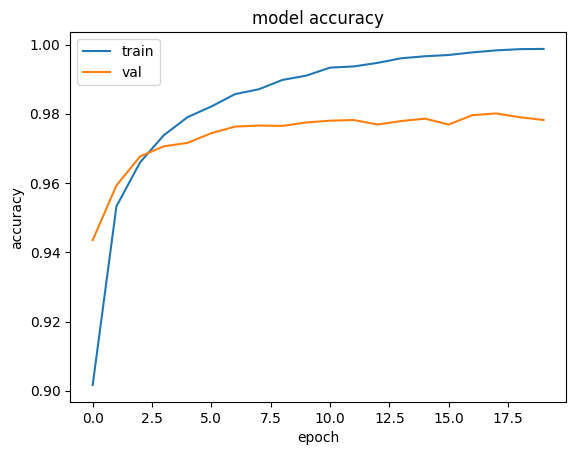

In [ ]:
plt.plot(history_128.history['accuracy'])
plt.plot(history_128.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

Remember that we used a dense layer with 128 neurons? That dense layer learned the patterns in the images to classify the images. What if we used more, say, 2048 neurons? Would the accuracy be higher, and how much larger would the model become? Let's find out.

In [ ]:
model_2048 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(10)
])

model_2048.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [ ]:
results_2048 = model_2048.evaluate(dataset_train)
print("Our training loss and accuracy:", results_2048)

results_2048 = model_2048.evaluate(dataset_test)
print("Our testing loss and accuracy:", results_2048)

469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0919 - loss: 2.3237
Our training loss and accuracy: [2.3232922554016113, 0.09171666949987411]
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0944 - loss: 2.3189
Our testing loss and accuracy: [2.3198940753936768, 0.09080000221729279]


In [ ]:
history_2048 = model_128.fit(
    # which dataset should we use to train?
    dataset_train,

    epochs=20,
    validation_data=dataset_test,
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9992 - loss: 0.0056 - val_accuracy: 0.9785 - val_loss: 0.0779
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9996 - loss: 0.0044 - val_accuracy: 0.9779 - val_loss: 0.0888
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9983 - loss: 0.0074 - val_accuracy: 0.9798 - val_loss: 0.0824
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9993 - loss: 0.0043 - val_accuracy: 0.9790 - val_loss: 0.0800
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9998 - loss: 0.0024 - val_accuracy: 0.9803 - val_loss: 0.0817
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 0.9742 - val_loss: 0.1024
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9983 - loss: 0.0068 - val_accuracy: 0.9786 - val_loss: 0.0931
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9988 - loss: 0.0045 - val_accuracy: 0.

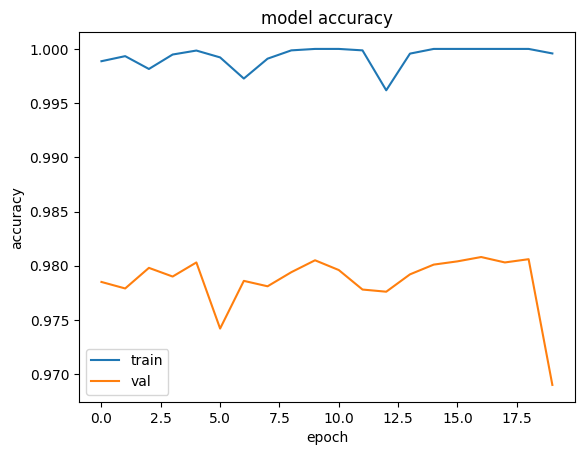

In [ ]:
plt.plot(history_2048.history['accuracy'])
plt.plot(history_2048.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

You may have noticed the model started off outperforming the smaller model on validation dataset (>98% versus 97.8%), but started performing worse at the end.That's beacuse it's started memorizing the training data instead of generalizing well to newer data (look at training accuracy). We want to focus on maximizing the accuracy of model without using too many parameters, as it prevents overfitting.
Now let's use model_name.summary() to check the size of the model in terms of parameters, to balance model accuracy with use of computational resources.

In [ ]:
model_128.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,312 (1.16 MB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 203,542 (795.09 KB)

In [ ]:
model_2048.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2048)                │       1,607,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,628,170 (6.21 MB)

 Trainable params: 1,628,170 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

Now we introduce Convolutional Neural Networks, one of the most popular and used deep learning networks. To visualize the CNN structure, look at https://anonymous-startup-sheller.vercel.app/
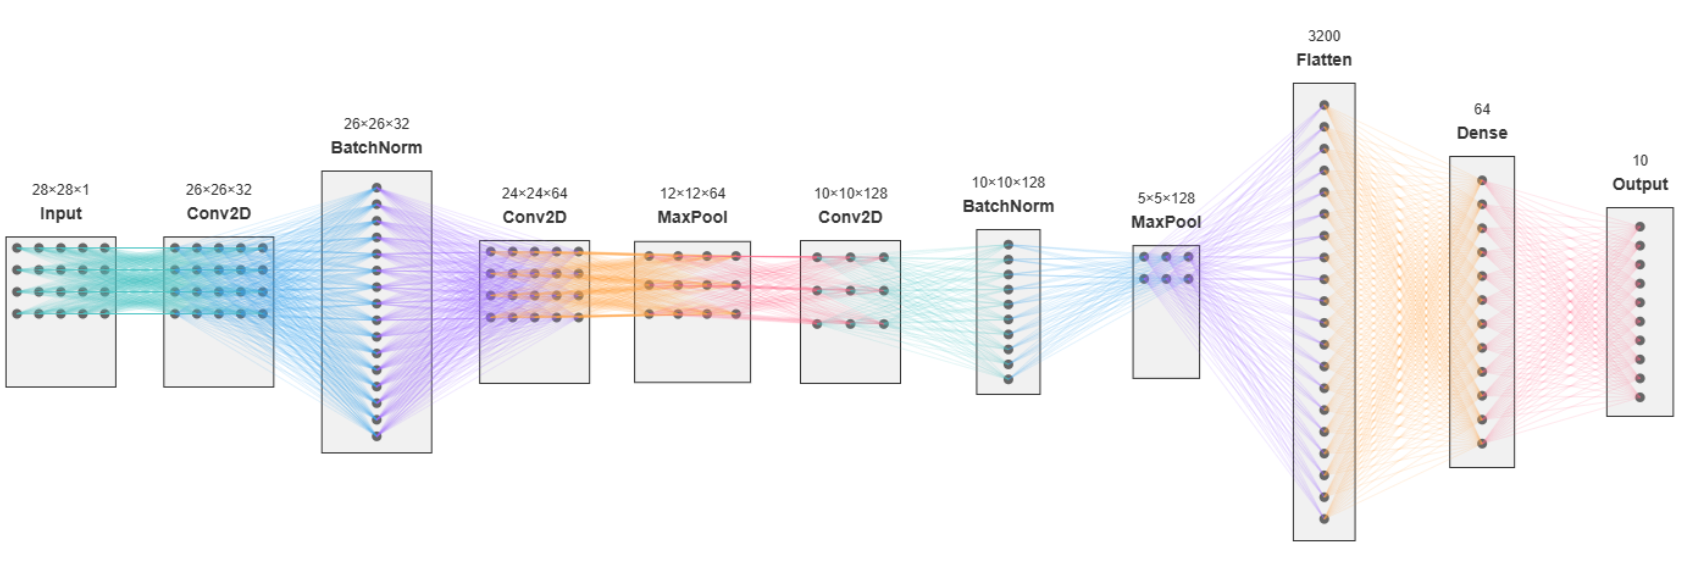

In [ ]:
input_img = Input(shape=(28, 28, 1))

layer0 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_img)  # 26x26x32
layer1 = BatchNormalization()(layer0)
layer2 = Conv2D(64, (3, 3), activation='relu')(layer1)  # 24x24x64
layer3 = MaxPooling2D(pool_size=(2, 2))(layer2)  # 12x12x64
layer4 = Conv2D(128, (3, 3), activation='relu')(layer3)  # 10x10x128
layer5 = BatchNormalization()(layer4)
layer6 = MaxPooling2D(pool_size=(2, 2))(layer5)  # 5x5x128
layer7 = Dropout(0.5)(layer6)
layer8 = Flatten()(layer7)  # 3200 (5*5*128)
layer9 = Dense(64, activation='relu')(layer8)
layer10 = Dropout(0.25)(layer9)
layer11 = Dense(10, activation='softmax')(layer10)

model_CNN = Model(input_img, layer11)

# Understanding the CNN Architecture: Layer by Layer

Let’s break down this Convolutional Neural Network (CNN) and see what each part does, step by step!

## Starting Point: The Input Layer
The journey begins when the computer receives small black-and-white pictures of handwritten numbers, each 28x28 pixels in size. These images are fed into the `Input` layer, which is designed to handle pictures with a shape of `(28, 28, 1)`—meaning 28 pixels wide, 28 pixels tall, and 1 color channel (since they’re grayscale).

---

# Layer 1: Conv2D (32 filters, 3x3 kernel)
- **What it does**: This is the first convolutional layer. It uses 32 filters (or kernels) to scan the image for basic features like edges, curves, or lines. Each filter looks at a 3x3 pixel area at a time and slides across the entire image to detect these features (performing dot product on each pixel area and building a matrix of dot products).
- **Output**: It produces 32 feature maps, each of size 26x26 pixels, highlighting where these basic clues are found in the image.

# Layer 2: BatchNormalization
- **What it does**: This layer takes the outputs from Layer 1 (the 32 feature maps of size 26x26) and normalizes them. But what does "normalize" mean here? It adjusts the values so that, across each batch of images during training, they have a mean of roughly 0 and a standard deviation of about 1. Then, it applies a learnable scaling and shifting step to fine-tune these values. This process helps the model learn faster and more stably, avoiding situations where it gets stuck or takes forever to train.
- **Output**: The same 26x26x32 feature maps, but now normalized and adjusted to be more consistent across the batch.

### Do We Need BatchNormalization if Images Are Already Scaled to [0,1]?
You might wonder: "Wait a sec, I’ve already converted my images to floats and divided by 255 to get them in the [0,1] range. Isn’t that enough normalization?" Great question! Scaling the input images to [0,1] is a fantastic start—it ensures the raw data isn’t wildly large (like 0-255), which could overwhelm the network. But here’s the catch: that scaling only applies to the *input*. As the data flows through Layer 1 (the Conv2D), the outputs (those feature maps) can still end up with values that vary a lot—some might be tiny, others huge—depending on the weights, biases, and activation function (ReLU here).

Plus, it reduces something called "internal covariate shift"—a fancy way of saying it keeps the data distribution stable as the model learns, so the later layers don’t have to constantly adjust to shifting inputs.

### Why It Helps
- **Faster Learning**: By keeping values in a sweet spot (mean ~0, std ~1), gradients flow better, and the model can take bigger, more confident steps during optimization.
- **Stability**: Without it, deeper layers (like Layer 5 or beyond) might struggle if earlier layers produce wonky outputs.
- **Less Sensitivity**: It makes the model less picky about things like learning rate or weight initialization.

### Do We *Need* It?
Strictly speaking, you *could* skip BatchNormalization and still train a model. But for a CNN like this—designed for handwritten digits with multiple layers—BatchNormalization is like a turbo boost. It’s not just about the input range; it’s about keeping the whole pipeline smooth and efficient. Studies (and lots of experiments) show it often improves accuracy and cuts training time, even in models that already have scaled inputs.

So, while not 100% mandatory, it’s a smart addition here—especially since this CNN aims for high accuracy without too many parameters!

---

# Layer 3: Conv2D (64 filters, 3x3 kernel)
- **What it does**: Building on the previous layer, this convolutional layer uses 64 filters to detect more complex patterns, such as where lines intersect or curves connect.
- **Output**: It generates 64 feature maps, each 24x24 pixels, capturing richer details from the image.

---

# Layer 4: MaxPooling2D (2x2 pool size)
- **What it does**: This pooling layer simplifies the feature maps by reducing their size. It looks at 2x2 pixel areas in each feature map and keeps only the most important value (the maximum value) from each area.
- **Output**: The feature maps are shrunk to 12x12x64, retaining the key information while making the data easier to process.

---

# Layer 5: Conv2D (128 filters, 3x3 kernel)
- **What it does**: This layer goes even deeper, using 128 filters to detect highly specific features, such as the exact shape of a loop in a '9' or the angle in a '7'.
- **Output**: It produces 128 feature maps, each 10x10 pixels, packed with fine-tuned details.

---

# Layer 6: BatchNormalization
- **What it does**: Similar to Layer 2, this normalization step ensures that the outputs from Layer 5 are stable and consistent, helping the model learn efficiently as it processes more complex patterns.
- **Output**: The same 10x10x128 feature maps, but normalized.

---

## Layer 7: MaxPooling2D (2x2 pool size)
- **What it does**: Another pooling layer that further reduces the size of the feature maps. It takes 2x2 pixel areas from each map and keeps the maximum value, simplifying the data even more.
- **Output**: The feature maps are now 5x5x128, focusing only on the most critical information.

---

## Layer 8: Dropout (0.5)
- **What it does**: This layer introduces a clever trick to prevent overfitting. During training, it randomly "turns off" 50% of the neurons, forcing the model to learn more robust and general patterns rather than memorizing the training data.
- **Output**: The same 5x5x128 feature maps, but with some neurons temporarily ignored during training.

---

## Layer 9: Flatten
- **What it does**: This layer transforms the 3D feature maps (5x5x128) into a 1D list of 3,200 numbers (since 5*5*128 = 3,200). This flattening is necessary because the next layers (dense layers) expect a flat input.
- **Output**: A 1D vector of 3,200 values.

---

## Layer 10: Dense (64 units, ReLU activation)
- **What it does**: This fully connected layer has 64 neurons, each of which looks at the entire 3,200-number list. It learns to combine the features detected earlier to identify patterns that suggest specific digits (e.g., distinguishing a '0' from a '5').
- **Output**: A set of 64 values, each representing a higher-level feature.

---

## Layer 11: Dropout (0.25)
- **What it does**: Another dropout layer, this time turning off 25% of the neurons during training. This helps fine-tune the model's ability to generalize by preventing it from relying too heavily on specific neurons.
- **Output**: The same 64 values, but with some neurons temporarily ignored during training.

---

## Layer 12: Dense (10 units, softmax activation)
- **What it does**: The final layer! It has 10 neurons, each corresponding to one digit from 0 to 9. Using the softmax activation function, it converts the outputs into probabilities, indicating how likely the input image is to be each digit.
- **Output**: A probability distribution over the 10 possible digits, with the highest probability indicating the model's prediction.

---

## Why It Works So Well
This CNN is incredibly efficient. Each layer plays a crucial role, from detecting basic shapes to making the final prediction, all while avoiding common pitfalls like overfitting. The combination of convolutional layers for feature extraction, maxpooling for simplification, normalization for stability, dropout for generalization, and dense layers for decision-making makes this model both powerful and efficient.

In [ ]:
model_CNN.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

history_CNN = model_CNN.fit(
    # which dataset should we use to train?
    dataset_train,

    epochs=20,
    validation_data=dataset_test,
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8537 - loss: 0.4920 - val_accuracy: 0.9251 - val_loss: 0.2679
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9722 - loss: 0.0940 - val_accuracy: 0.9875 - val_loss: 0.0405
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9805 - loss: 0.0651 - val_accuracy: 0.9889 - val_loss: 0.0338
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9836 - loss: 0.0535 - val_accuracy: 0.9851 - val_loss: 0.0522
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9853 - loss: 0.0502 - val_accuracy: 0.9905 - val_loss: 0.0298
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9865 - loss: 0.0468 - val_accuracy: 0.9924 - val_loss: 0.0257
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9878 - loss: 0.0376 - val_accuracy: 0.9883 - val_loss: 0.0382
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9883 - loss: 0.0397 - val_accu

Now let's use our model to make predictions on our test set and display them.


To do so, we first unbatch our test dataset so we only grab a random sample of 1 image and label at a time instead of 128 of them.

Next we use the model to make a prediction on the image. We can print out that prediction but it isn't very useful to us humans yet. We need to first take the arg-max, or the index position of the maximum value of the prediction.

In [ ]:
results = model_CNN.evaluate(dataset_train)
print("Our training loss and accuracy:", results)

results = model_CNN.evaluate(dataset_test)
print("Our testing loss and accuracy:", results)

469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9989 - loss: 0.0039
Our training loss and accuracy: [0.004385666456073523, 0.9987666606903076]
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9947 - loss: 0.0213
Our testing loss and accuracy: [0.023167360574007034, 0.9943000078201294]


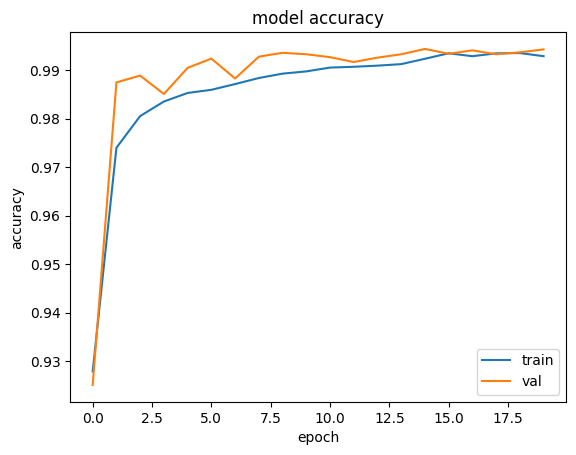

In [ ]:
plt.plot(history_CNN.history['accuracy'])
plt.plot(history_CNN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
model_CNN.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 64)                  │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 895,840 (3.42 MB)

 Trainable params: 298,506 (1.14 MB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 597,014 (2.28 MB)

In [ ]:
dataset_test = dataset_test.unbatch()
dataset_test = dataset_test.shuffle(buffer_size=dataset_info.splits['test'].num_examples)

Feel free to run this as many times as you want to see different images and the model's predictions.
Are there times when the model does better than you, or when you do better than it?


(1, 28, 28, 1) ()
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
This is the prediction without it being processed first:
 [[9.9993591e-37 2.2786060e-20 3.0675218e-20 1.0000000e+00 9.0261957e-29
  6.3401173e-11 2.6898534e-30 1.6395092e-21 7.4463367e-20 4.4690956e-20]]

The model's prediction for the image: 3
The actual label: 3


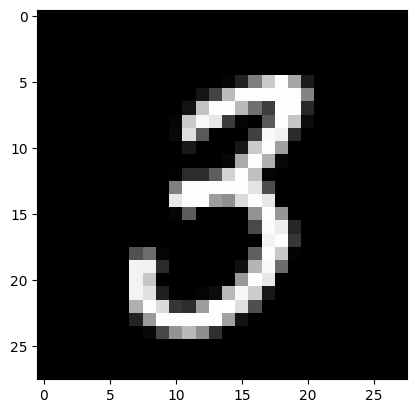

In [ ]:
def random_prediction():
    img, label = list(dataset_test.take(1))[0]
    img = tf.reshape(img, (-1, 28, 28, 1))
    print(img.shape, label.shape)

    prediction = model_CNN.predict(img)
    print("This is the prediction without it being processed first:\n", prediction)

    processed_prediction = tf.math.argmax(prediction[0])

    print("\nThe model's prediction for the image:", int(processed_prediction))
    print("The actual label:", int(label))
    plt.imshow(img[0,:,:,0], cmap="gray")


random_prediction()

Let's make a confusion matrix to look at how well the model is at recognizing specific numbers. As expected, 1 is the most accurate number and 5 is least accurate, because 1 is simply a line and 5 has more curves and edges.

all_images shape: (10000, 28, 28, 1)
all_labels shape: (10000,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


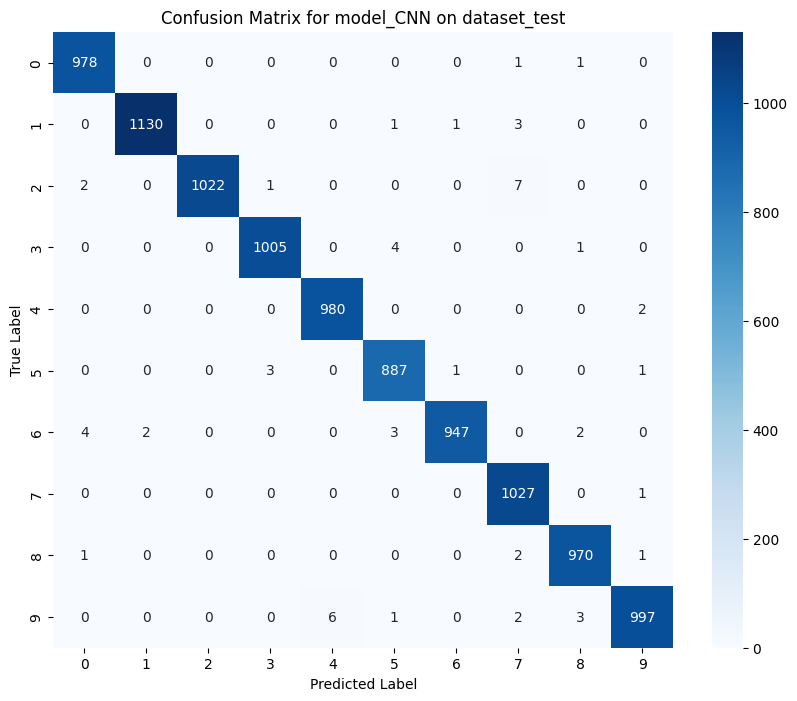

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to process dataset_test and make predictions
def predict_and_heatmap():
    # Lists to store all images and labels
    all_images = []
    all_labels = []

    # Loop through dataset_test to collect all images and labels
    for img, label in dataset_test:
        # Reshape each image to match model input: (1, 28, 28, 1)
        img = tf.reshape(img, (-1, 28, 28, 1))
        all_images.append(img.numpy())  # Convert to numpy array
        all_labels.append(label.numpy())  # Convert to numpy array

    # Stack all images into a single numpy array
    all_images = np.vstack(all_images)  # Shape: (num_samples, 28, 28, 1)
    all_labels = np.array(all_labels)  # Shape: (num_samples,)

    # Check shapes
    print("all_images shape:", all_images.shape)
    print("all_labels shape:", all_labels.shape)

    # Ensure images are float32 and in [0,1] range
    all_images = all_images.astype('float32')
    if all_images.max() > 1.0:  # If values are 0-255
        all_images /= 255.0

    # Make predictions for all images
    predictions = model_CNN.predict(all_images)  # Shape: (num_samples, 10)
    predicted_labels = np.argmax(predictions, axis=1)  # Shape: (num_samples,)

    # If labels are one-hot encoded, convert to class indices
    if len(all_labels.shape) > 1 and all_labels.shape[-1] > 1:
        all_labels = np.argmax(all_labels, axis=1)

    # Create confusion matrix
    conf_matrix = confusion_matrix(all_labels, predicted_labels)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix for model_CNN on dataset_test')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Run the function
predict_and_heatmap()